# Plataforma BNB Linked Data

La [plataforma BNB Linked Data](https://bnb.data.bl.uk/) proporciona acceso a la [British National Bibliography (BNB)](http://www.bl.uk/bibliographic/natbib.html) a través de un punto de acceso SPARQL. 

Este notebook muestra cómo obtener obras relacionadas con un autor, así como también, los lugares de publicación (campos blt:publication y blt:projectedPublication) para crear un mapa interactivo. 

## Configuración global

Damos valor al recurso de autoridad con el que trabajaremos para crear el mapa interactivo.

In [1]:
#bnbIdAutor = 'http://bnb.data.bl.uk/id/person/DickensCharles1812-1870'
#bnbIdAutor = 'http://bnb.data.bl.uk/id/person/BlakeWilliam1757-1827'
#bnbIdAutor = 'http://bnb.data.bl.uk/id/person/WoolfVirginia1882-1941'
#bnbIdAutor = 'http://bnb.data.bl.uk/id/person/ShakespeareWilliam1564-1616'
bnbIdAutor = 'http://bnb.data.bl.uk/id/person/CervantesSaavedraMiguelde1547-1616'

## Importamos las librerías de software

In [2]:
import folium
import requests
import pandas as pd
import json
import csv
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize  

## Obtenemos las obras relacionadas con el autor William Shakespeare

In [3]:
url = 'https://bnb.data.bl.uk/sparql'
sentencia = """
PREFIX blt: <http://www.bl.uk/schemas/bibliographic/blterms#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX c4dm: <http://purl.org/NET/c4dm/event.owl#>

SELECT DISTINCT ?recurso ?titulo ?fecha ?lugar WHERE {{
    graph <http://bnb.data.bl.uk/id/graph/BNBCIP> {{
      ?recurso ?p <{0}> ;
         dct:title ?titulo ;
         schema:datePublished ?fecha .
      OPTIONAL {{
          ?recurso blt:projectedPublication ?publicacion .
          ?publicacion c4dm:place ?lugar .
          FILTER regex(?lugar, "geonames", "i")        
      }}
      OPTIONAL {{
          ?recurso blt:publication ?publicacion .
          ?publicacion c4dm:place ?lugar .
          FILTER regex(?lugar, "geonames", "i")        
      }}
    }}
}} LIMIT 500
"""

sentencia = sentencia.format(bnbIdAutor)

# usamos json como resultado
cabeceras = {'Accept': 'application/sparql-results+json'}
r = requests.get(url, params = {'format': 'application/sparql-results+json', 'query': sentencia}, headers=cabeceras)

print(r.text)


{ "head": { "link": [], "vars": ["recurso", "titulo", "fecha", "lugar"] },
  "results": { "distinct": false, "ordered": true, "bindings": [
    { "recurso": { "type": "uri", "value": "http://bnb.data.bl.uk/id/resource/019800347" }	, "titulo": { "type": "literal", "value": "Exemplary stories" }	, "fecha": { "type": "literal", "value": "2020-05" }	, "lugar": { "type": "uri", "value": "http://sws.geonames.org/6252001/" }},
    { "recurso": { "type": "uri", "value": "http://bnb.data.bl.uk/id/resource/018557368" }	, "titulo": { "type": "literal", "value": "The history and adventures of the renowned Don Quixote" }	, "fecha": { "type": "literal", "value": "2017-10" }	, "lugar": { "type": "uri", "value": "http://sws.geonames.org/6252001/" }},
    { "recurso": { "type": "uri", "value": "http://bnb.data.bl.uk/id/resource/019553770" }	, "titulo": { "type": "literal", "value": "The complete Don Quixote of La Mancha" }	, "fecha": { "type": "literal", "value": "2019-09" }	, "lugar": { "type": "uri"

## Guardamos el resultado como un fichero CSV 

In [4]:
bnbdatos = json.loads(r.text)

with open('bnb_registros.csv', 'w', newline='') as fichero:
    csv_salida = csv.writer(fichero, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)    

    csv_salida.writerow(['recurso', 'lugar', 'titulo', 'fecha'])

    for i in bnbdatos['results']['bindings']:
        recurso = lugar = titulo = fecha =''

        recurso = i['recurso']['value']
        #if "lugar" in i:
        lugar = i['lugar']['value']
        titulo = i['titulo']['value']
        fecha = i['fecha']['value']

        csv_salida.writerow([recurso,lugar,titulo,fecha])

## Explorando los datos

In [5]:
df = pd.read_csv('bnb_registros.csv')

In [6]:
df

,recurso,lugar,titulo,fecha
0,http://bnb.data.bl.uk/id/resource/019800347,http://sws.geonames.org/6252001/,Exemplary stories,2020-05
1,http://bnb.data.bl.uk/id/resource/018557368,http://sws.geonames.org/6252001/,The history and adventures of the renowned Don...,2017-10
2,http://bnb.data.bl.uk/id/resource/019553770,http://sws.geonames.org/6252001/,The complete Don Quixote of La Mancha,2019-09
3,http://bnb.data.bl.uk/id/resource/019559061,http://sws.geonames.org/6269131/,Don Quixote,2019-10
4,http://bnb.data.bl.uk/id/resource/014926909,http://sws.geonames.org/6252001/,Don Quixote,2009-05
5,http://bnb.data.bl.uk/id/resource/018299510,http://sws.geonames.org/6252001/,Don Quixote,2017-04
6,http://bnb.data.bl.uk/id/resource/018812620,http://sws.geonames.org/6252001/,Don Quixote,2018-04
7,http://bnb.data.bl.uk/id/resource/018861452,http://sws.geonames.org/6269131/,Don Quixote,2018-07
8,http://bnb.data.bl.uk/id/resource/018419681,http://sws.geonames.org/6269131/,Don Quixote,2017-09
9,http://bnb.data.bl.uk/id/resource/020025106,http://sws.geonames.org/6252001/,Don Quixote,2020-11


## ¿Cuántos registros hemos recuperado?

In [7]:
len(df)

11

### Vamos a contar el número de resultados por lugar

In [8]:
lugares_por_recurso = df.groupby("lugar")["recurso"].count()

In [9]:
lugares_por_recurso

lugar
http://sws.geonames.org/6252001/    8
http://sws.geonames.org/6269131/    3
Name: recurso, dtype: int64

### Creamos una gráfica para visualizar los recursos por fecha

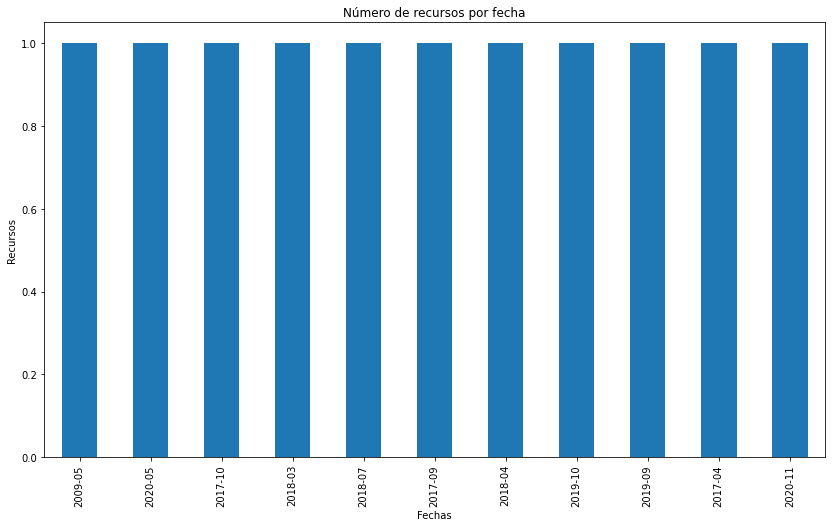

In [10]:
ax = df['fecha'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Número de recursos por fecha")
ax.set_xlabel("Fechas")
ax.set_ylabel("Recursos")
plt.show()

### Agrupamos los elementos por año

In [11]:
df['año'] = pd.DatetimeIndex(df['fecha']).year

In [12]:
df['año']

0     2020
1     2017
2     2019
3     2019
4     2009
5     2017
6     2018
7     2018
8     2017
9     2020
10    2018
Name: año, dtype: int64

### Creamos una gráfica por año

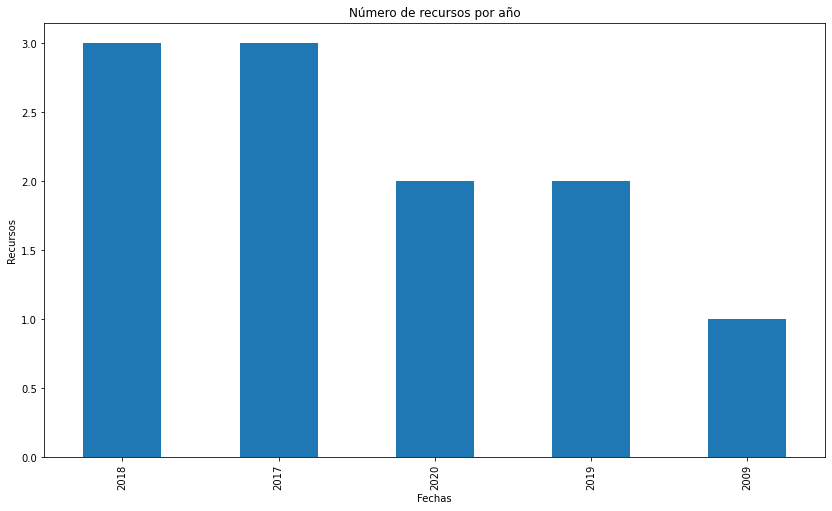

In [13]:
ax = df['año'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Número de recursos por año")
ax.set_xlabel("Fechas")
ax.set_ylabel("Recursos")
plt.show()

## Explorando los lugares

In [14]:
lugares = pd.unique(df['lugar']).tolist()
cadena_lugares = ''
for a in sorted(lugares):
    print(a)
    cadena_lugares = cadena_lugares + ' \"' + a.replace("http://sws.geonames.org/", "").replace("/", "") + '\"'

http://sws.geonames.org/6252001/
http://sws.geonames.org/6269131/


### Obtenemos la latitud y la longitud de Wikidata

In [15]:
url = 'https://query.wikidata.org/sparql'
sentencia = """
SELECT ?idgeonames ?lat ?lon ?x ?xLabel 
WHERE {{ 
  values ?idgeonames {{ {0} }} 
  ?x wdt:P1566 ?idgeonames ; 
   p:P625 [
     psv:P625 [
       wikibase:geoLatitude ?lat ;
       wikibase:geoLongitude ?lon ;
       wikibase:geoGlobe ?globe ;
     ];
     ps:P625 ?coord
   ]
   SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
}}
"""

sentencia = sentencia.format(cadena_lugares)
#print(sentencia)

r = requests.get(url, params = {'format': 'json', 'query': sentencia})
puntos_geo = r.json()

### Finalmente, añadimos los marcadores al mapa

In [16]:
mapa = folium.Map(location=[0,0], zoom_start=1.5)

for geo in puntos_geo['results']['bindings']:
    idwikidata = geo['x']['value']
    lat = geo['lat']['value']
    lon = geo['lon']['value']
    idgeonames = geo['idgeonames']['value']
    etiqueta = geo['xLabel']['value']
    print(lat, lon)
    
    # adding a text to the popup
    count = lugares_por_recurso[['http://sws.geonames.org/' + idgeonames + '/']][0]
    texto_popup = str(count) + " registros publicados en <a hreh='" + str(idwikidata) + "'>" + etiqueta + "</a>"
    
    folium.Marker([lat,lon], popup= texto_popup).add_to(mapa)

39.828175 -98.5795
53.0 -1.0


In [17]:
mapa

## Añadiendo áreas
Folium permite la inserción de áreas para mejorar el aspecto y entendimiento del mapa obtenido como resultado. Multiplicamos el radio por un número que sea representativo y permita visualizar correctamente el área.

In [46]:
mapa_circulos = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)

for geo in puntos_geo['results']['bindings']:
    
    count = lugares_por_recurso[['http://sws.geonames.org/' + idgeonames + '/']][0]
    print(count)
    
    etiqueta = geo['xLabel']['value']
    idwikidata = geo['x']['value']
    texto_popup = str(count) + " registros publicados en <a hreh='" + str(idwikidata) + "'>" + etiqueta + "</a>"

    
    folium.Circle(
      location=[geo['lat']['value'], geo['lon']['value']],
      popup=texto_popup,
      radius=float(count)*30000,
      color='crimson',
      fill=True,
      fill_color='crimson'
    ).add_to(mapa_circulos)

3
3


In [47]:
mapa_circulos